# IDEA: Train on the derivative

Task: Predict the time series: $U_i$, i = 0, ... N with a constant sampling time of $dt$

Update rule for training:

$$
r_{i+1} = f(A\cdot r_i + W_{in}\cdot u_i)
$$

Update rule closed loop:
$$
r_{i+1} = f(A\cdot r_i + W_{in}\cdot \hat u_i)
$$
$$
x_{i+1} = W_{out} \cdot r_{i+1}
$$
$$
\hat u_{i+1} = \hat u_i + x_{i+1} dt = \hat u_i + W_{out} \cdot r_{i+1} \cdot dt
$$
------
$$
\Delta u_i = (u_{i+1} - u_{i})/dt
$$

Train reservoir on difference:

# Imports:

In [59]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 7)
import seaborn as sns
import pandas as pd

import rescomp
import rescomp.statistical_tests as st

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Time-Series Data:

### Lorenz iterator:

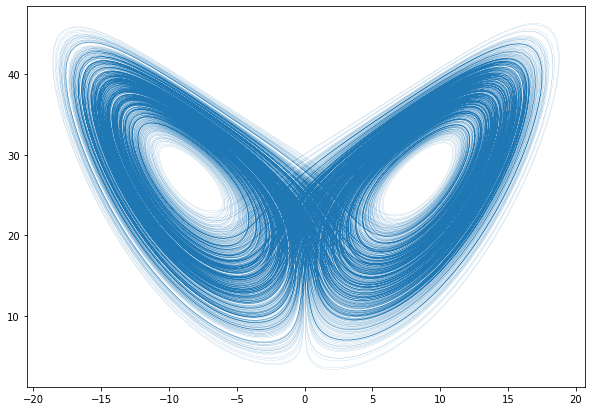

In [2]:
# Lorenz parameters:
dt_L = 0.01
lyap_L = 0.934
starting_point_L = np.array([0, 1, 0])
# starting_point_L = np.array([-14.03020521, -20.88693127, 25.53545])

# lorenz iterator:
def data_creation_function_L(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function_L(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 100000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series_L = time_series_all[disc_steps:, :]

plt.plot(time_series_L[:, 0], time_series_L[:, 2], linewidth=0.1)

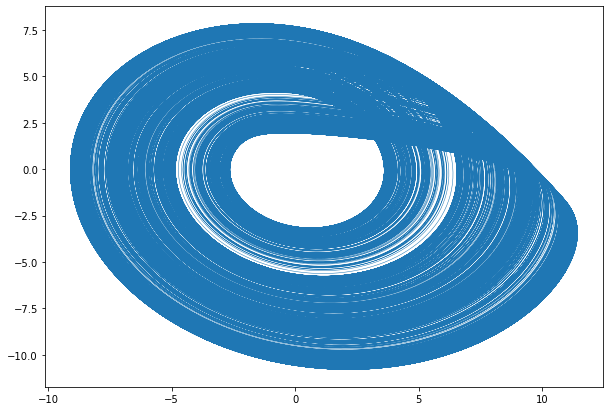

In [3]:
# Roessler parameters:
dt_R = 0.05
lyap_R = 1
starting_point_R = np.array([0, 1, 0])

# Roessler iterator:
def data_creation_function_R(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("roessler_sprott", dt, time_steps, starting_point)

def f_R(x):
    return data_creation_function_R(2, dt_R, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 100000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_R

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_R(x_last)

time_series_R = time_series_all[disc_steps:, :]

plt.plot(time_series_R[:, 0], time_series_R[:, 1], linewidth=0.5)

In [4]:
dt = dt_L
time_series = time_series_L

# Single RC:

## Create difference-RC architecture and baseline:

In [ ]:
# Difference:
esn_diff = rescomp.esn.ESNDifference(dt)
esn_diff.set_console_logger("debug")
ndim = 25 #150
# esn_diff.create_architecture(ndim, 3, w_out=np.random.randn(3, ndim), seed=120, w_out_fit_flag="simple", leak_fct=0.0, activation_function="tanh")
esn_diff.create_architecture(ndim, 3, w_out=np.random.randn(3, ndim), seed=120, w_out_fit_flag="simple", leak_fct=0.7, activation_function="sigmoid")
esn_diff.summary()

In [ ]:
# Baseline:
esn_base = rescomp.esn.ESNWrapper()
esn_base.set_console_logger("debug")
ndim = 25 #150
esn_base.create_architecture(ndim, 3, w_out=np.random.randn(3, ndim), seed=120, w_out_fit_flag="simple", leak_fct=0.7, activation_function="tanh")
esn_base.summary()

In [ ]:
# Check if same network:
(esn_base.get_network(as_array=True) == esn_diff.get_network(as_array=True)).all()

## Training:

In [ ]:
train_sync_steps = 150
train_steps = 10000
reg_param = 1e-7
x_train = time_series[:train_sync_steps + train_steps]

esn_diff.train(x_train, sync_steps=train_sync_steps, reg_param=reg_param, w_in_no_update=True)
esn_base.train(x_train, sync_steps=train_sync_steps, reg_param=reg_param, w_in_no_update=True)

## Predict:

In [ ]:
test_sync_steps = 1000
test_steps = 5000

x_test = time_series[train_sync_steps + train_steps : train_sync_steps + train_steps + test_sync_steps + test_steps]

In [ ]:
# difference:
esn_diff.reset_res_state()
y_pred, y_test = esn_diff.predict(x_pred=x_test, sync_steps=test_sync_steps, save_r=True)
r = esn_diff._r_pred.copy()

plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1, label="true")
plt.plot(y_pred[:, 0], y_pred[:, 2], linewidth=1, label="pred")

plt.legend()
# plt.xlim(-50, 50)

plt.subplot(122)
plt.imshow(r.T, aspect="auto")
plt.colorbar()

plt.figure(figsize=(13, 10))
for ix in range(3):
    plt.subplot(f"31{ix+1}")
    plt.plot(y_test[:, ix], linewidth=1, label="test")
    plt.plot(y_pred[:, ix], linewidth=1, label="pred")
    plt.legend()

In [ ]:
# Baseline:
esn_base.reset_res_state()
y_pred, y_test = esn_base.predict(x_pred=x_test, sync_steps=test_sync_steps, save_r=True)
r = esn_base._r_pred.copy()

plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1, label="true")
plt.plot(y_pred[:, 0], y_pred[:, 2], linewidth=1, label="pred")
plt.legend()
plt.xlim(-50, 50)

plt.subplot(122)
plt.imshow(r.T, aspect="auto")
plt.colorbar()

plt.figure(figsize=(13, 10))
for ix in range(3):
    plt.subplot(f"31{ix+1}")
    plt.plot(y_test[:, ix], linewidth=1, label="test")
    plt.plot(y_pred[:, ix], linewidth=1, label="pred")
    plt.legend()

# Ensemble Experiment:

In [6]:
t_train_disc = 0
t_train_sync = 100
t_train = 5000
t_pred_disc = 1000
t_pred_sync = 100
t_pred = 2000
nr_of_time_intervals = 5

x_train, x_pred_list, sim_data = st.data_simulation(time_series, t_train_disc, t_train_sync, t_train,
                                                         t_pred_disc, t_pred_sync, t_pred, nr_of_time_intervals=nr_of_time_intervals,
                                                         sim_data_return = True)

train_disc_steps:  0
train_sync_steps:  100
train_steps:  5000
pred_disc_steps:  1000
pred_sync_steps:  100
pred_steps:  2000
total_time_steps:  20600
................................
x_train shape:  (5100, 3)
x_pred_list shape : (5, 2100, 3)
sim_data shape : (100000, 3)


## Initialize statistical tester class:

In [ ]:
res_dim = 50
leak_fct = 0.5
activation_function = "sigmoid"
# activation_function = "tanh"


In [ ]:
tester_diff = st.StatisticalModelTester()

def diff_model_creation_function():
    # Difference:
    esn_diff = rescomp.esn.ESNDifference(dt)
    esn_diff.set_console_logger("debug")
    ndim = res_dim
    esn_diff.create_architecture(ndim, 3, w_out=np.random.randn(3, ndim), seed=None, w_out_fit_flag="simple", leak_fct=leak_fct, activation_function=activation_function)
    esn_diff.train(x_train, sync_steps=t_train_sync, reg_param=reg_param, w_in_no_update=True)
    return esn_diff

def diff_model_prediction_function(x_pred, model):
    model.reset_res_state()
    return model.predict(x_pred=x_pred, sync_steps=t_pred_sync, save_r=False)

tester_diff.set_model_creation_function(diff_model_creation_function)
tester_diff.set_model_prediction_function(diff_model_prediction_function)

In [ ]:
tester_base = st.StatisticalModelTester()

def base_model_creation_function():
    # Difference:
    esn_base = rescomp.esn.ESNWrapper()
    esn_base.set_console_logger("debug")
    ndim = res_dim
    esn_base.create_architecture(ndim, 3, w_out=np.random.randn(3, ndim), seed=None, w_out_fit_flag="simple", leak_fct=leak_fct, activation_function=activation_function)
    esn_base.train(x_train, sync_steps=t_train_sync, reg_param=reg_param, w_in_no_update=True)
    return esn_base

def base_model_prediction_function(x_pred, model):
    model.reset_res_state()
    return model.predict(x_pred=x_pred, sync_steps=t_pred_sync, save_r=False)

tester_base.set_model_creation_function(base_model_creation_function)
tester_base.set_model_prediction_function(base_model_prediction_function)

## Do ensemble experiment:

In [ ]:
np.random.seed(42)
output_flag = "full"
N_ens = 20

In [ ]:
tester_diff.do_ens_experiment_internal(N_ens, x_pred_list=x_pred_list)

tester_base.do_ens_experiment_internal(N_ens, x_pred_list=x_pred_list)

## Plotting:

In [ ]:
def plot_attractor(out):
    N_ens = out.shape[0]
    nr_of_time_intervals = out.shape[1]
    y_pred_all = out[:, :, 0, :, :]
    y_test_all = out[:, :, 1, :, :]
    fig, axs = plt.subplots(N_ens, nr_of_time_intervals, figsize=(5*nr_of_time_intervals, 5*N_ens))

    for i_ens in range(N_ens):
        for i_interval in range(nr_of_time_intervals):
            ax = axs[i_ens, i_interval]
            y_pred = y_pred_all[i_ens, i_interval, :, :]
            y_test = y_test_all[i_ens, i_interval, :, :]
            ax.plot(y_test[:, 0], y_test[:, 2], linewidth=1, label="true")
            ax.plot(y_pred[:, 0], y_pred[:, 2], linewidth=1, label="pred")
            ax.set_title(f"ENS: {i_ens}, Timeinterval: {i_interval}")
            ax.legend()

In [ ]:
# Difference Model:
out_diff = tester_diff.results
plot_attractor(out_diff)

In [ ]:
# Difference Model:
out_base = tester_base.results
plot_attractor(out_base)

In [ ]:
# Error:
error_diff = tester_diff.get_error(mean=True)
error_base = tester_base.get_error(mean=True)

plt.title("Mean Error over time")
plt.plot(error_diff, label="difference")
plt.plot(error_base, label="base")
plt.xlim(0, 100)
plt.ylim(0, 0.5)
plt.legend()

In [ ]:
# Valid times:
error_threshhold = 0.1

valid_times_diff = tester_diff.get_valid_times(mean=False, error_threshhold=error_threshhold)
plt.hist(valid_times_diff.flatten(), bins=20, alpha=0.3, label="difference")

valid_times_base = tester_base.get_valid_times(mean=False, error_threshhold=error_threshhold)
plt.hist(valid_times_base.flatten(), bins=20, alpha=0.3, label="base")

plt.legend()

# Parameter Sweep Ensemble Experiment:

In [29]:
t_train_disc = 0
t_train_sync = 100
t_train = 5000
t_pred_disc = 1000
t_pred_sync = 100
t_pred = 1000
nr_of_time_intervals = 30

x_train, x_pred_list, sim_data = st.data_simulation(time_series, t_train_disc, t_train_sync, t_train,
                                                         t_pred_disc, t_pred_sync, t_pred, nr_of_time_intervals=nr_of_time_intervals,
                                                         sim_data_return = True)

train_disc_steps:  0
train_sync_steps:  100
train_steps:  5000
pred_disc_steps:  1000
pred_sync_steps:  100
pred_steps:  1000
total_time_steps:  68100
................................
x_train shape:  (5100, 3)
x_pred_list shape : (30, 1100, 3)
sim_data shape : (100000, 3)


In [30]:
def model_creation_function(**kwargs):
    if kwargs["esn_type"] == "difference":
        esn = rescomp.esn.ESNDifference(dt)
    elif kwargs["esn_type"] == "base":
        esn = rescomp.esn.ESNWrapper()
    else:
        raise Exception("esn_type not recognized!")

    # esn.set_console_logger("debug")
    esn.set_console_logger("off")
    ndim = kwargs["ndim"]
    leak_fct = kwargs["leak_fct"]
    reg_param = kwargs["reg_param"]
    activation_function = kwargs["activation_function"]
    esn.create_architecture(ndim, 3, w_out=np.random.randn(3, ndim), seed=None, w_out_fit_flag="simple", leak_fct=leak_fct, activation_function=activation_function)
    esn.train(x_train, sync_steps=t_train_sync, reg_param=reg_param, w_in_no_update=True)
    return esn

def model_prediction_function(x_pred, model):
    model.reset_res_state()
    return model.predict(x_pred=x_pred, sync_steps=t_pred_sync, save_r=False)

In [75]:
np.random.seed(42)
N_ens = 50

parameters = {
    "esn_type": ["difference", "base"],
    "ndim": 300,
    "leak_fct": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "reg_param": [1e-7],
    "activation_function": "tanh"
}

sweep_tester = st.StatisticalModelTesterSweep()
sweep_tester.set_model_creation_function(model_creation_function)
sweep_tester.set_model_prediction_function(model_prediction_function)

In [76]:
sweep_tester.do_ens_experiment_sweep(N_ens, x_pred_list, **parameters)

Sweep: 1/18
{'esn_type': 'difference', 'ndim': 300, 'leak_fct': 0.0, 'reg_param': 1e-07, 'activation_function': 'tanh'}
Realization: 1/50 ...
Realization: 2/50 ...
Realization: 3/50 ...
Realization: 4/50 ...
Realization: 5/50 ...
Realization: 6/50 ...
Realization: 7/50 ...
Realization: 8/50 ...
Realization: 9/50 ...
Realization: 10/50 ...
Realization: 11/50 ...
Realization: 12/50 ...
Realization: 13/50 ...
Realization: 14/50 ...
Realization: 15/50 ...
Realization: 16/50 ...
Realization: 17/50 ...
Realization: 18/50 ...
Realization: 19/50 ...
Realization: 20/50 ...
Realization: 21/50 ...
Realization: 22/50 ...
Realization: 23/50 ...
Realization: 24/50 ...
Realization: 25/50 ...
Realization: 26/50 ...
Realization: 27/50 ...
Realization: 28/50 ...
Realization: 29/50 ...
Realization: 30/50 ...
Realization: 31/50 ...
Realization: 32/50 ...
Realization: 33/50 ...
Realization: 34/50 ...
Realization: 35/50 ...
Realization: 36/50 ...
Realization: 37/50 ...
Realization: 38/50 ...
Realization: 39

In [72]:
sweep_tester.get_error_sweep()

[({'esn_type': 'difference',
   'ndim': 300,
   'leak_fct': 0.0,
   'reg_param': 1e-07,
   'activation_function': 'tanh'},
  array([[[1.91368362e-04, 4.15643276e-04, 6.35434432e-04, ...,
           8.31987054e-01, 8.53675286e-01, 8.71975814e-01],
          [8.24697465e-05, 1.69236653e-04, 2.42085772e-04, ...,
           8.48494466e-02, 8.75336669e-02, 9.05143455e-02],
          [7.22475178e-05, 1.40490613e-04, 1.73350574e-04, ...,
           1.56140801e+00, 1.61704652e+00, 1.67561645e+00],
          ...,
          [3.86886658e-05, 4.58119392e-05, 1.60394036e-04, ...,
           2.09221156e-01, 1.92215466e-01, 1.77829242e-01],
          [1.11051861e-04, 2.48666640e-04, 3.79808169e-04, ...,
           3.98655633e-01, 3.92309193e-01, 3.84878412e-01],
          [5.93638253e-05, 1.09299317e-04, 1.49106206e-04, ...,
           2.32857640e+00, 2.46406979e+00, 2.58654168e+00]],
  
         [[8.23080354e-05, 1.76670487e-04, 2.76597167e-04, ...,
           1.05079092e+00, 1.02797466e+00, 1.00357

(-5, 20)

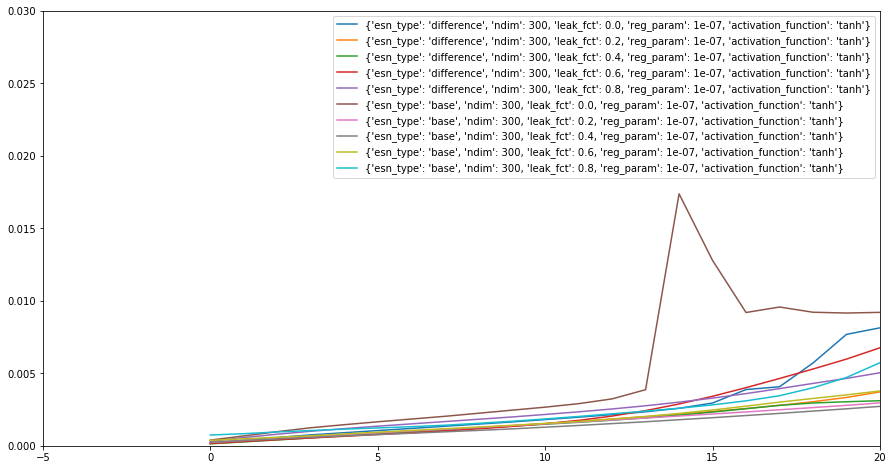

In [74]:
sweep_tester.plot_error()
plt.ylim(0, 0.03)
plt.xlim(-5, 20)

In [91]:
df_vt = sweep_tester.get_valid_times_df(error_threshhold=0.01)
df_vt

,esn_type,ndim,leak_fct,reg_param,activation_function,valid_times_mean,valid_times_median,valid_times_std,error_threshhold,nr_model_realizations,nr_of_time_intervals
0,difference,300,0.0,1.000000e-07,tanh,133.088000,122.0,78.057015,0.01,50,30
0,difference,300,0.1,1.000000e-07,tanh,133.638667,122.0,79.263140,0.01,50,30
0,difference,300,0.2,1.000000e-07,tanh,138.272000,124.0,83.092788,0.01,50,30
0,difference,300,0.3,1.000000e-07,tanh,140.832667,127.5,85.814571,0.01,50,30
0,difference,300,0.4,1.000000e-07,tanh,138.766667,126.0,84.656964,0.01,50,30
0,difference,300,0.5,1.000000e-07,tanh,136.029333,125.0,83.608001,0.01,50,30
0,difference,300,0.6,1.000000e-07,tanh,136.484000,123.0,85.242902,0.01,50,30
0,difference,300,0.7,1.000000e-07,tanh,119.986000,113.0,73.564361,0.01,50,30
0,difference,300,0.8,1.000000e-07,tanh,110.592667,104.0,68.093750,0.01,50,30
0,base,300,0.0,1.000000e-07,tanh,124.154667,116.0,78.120412,0.01,50,30


In [93]:
pd.options.plotting.backend = "plotly"
fig = df_vt.plot.line(x="leak_fct", y="valid_times_mean", color="esn_type", error_y="valid_times_std")
fig.show()

In [95]:
fig = df_vt.plot.line(x="leak_fct", y="valid_times_median", color="esn_type")
fig.show()

In [90]:
df_vt = sweep_tester.get_valid_times_df(error_threshhold=0.001)
df_vt
pd.options.plotting.backend = "plotly"
fig = df_vt.plot.line(x="leak_fct", y="valid_times_mean", color="esn_type", error_y="valid_times_std")
fig.show()

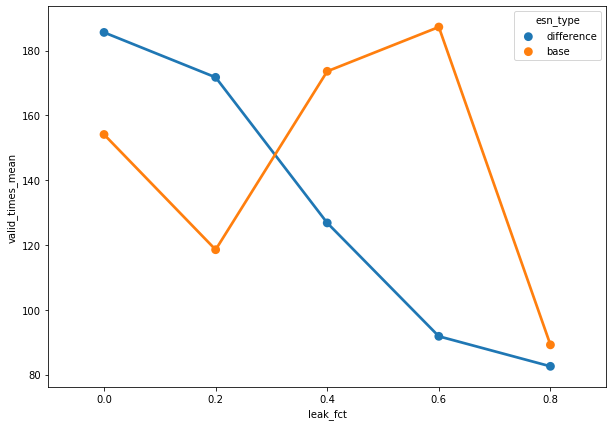

In [48]:
ax = sns.pointplot(x="leak_fct", y="valid_times_mean", hue="esn_type", data=df_vt)

In [156]:
sweep_tester.get_error_sweep()

[({'esn_type': 'difference',
   'ndim': 300,
   'leak_fct': 0.0,
   'reg_param': 1e-07,
   'activation_function': 'tanh'},
  array([[[1.91368362e-04, 4.15643276e-04, 6.35434432e-04, ...,
           8.31987054e-01, 8.53675286e-01, 8.71975814e-01],
          [8.24697465e-05, 1.69236653e-04, 2.42085772e-04, ...,
           8.48494466e-02, 8.75336669e-02, 9.05143455e-02],
          [7.22475178e-05, 1.40490613e-04, 1.73350574e-04, ...,
           1.56140801e+00, 1.61704652e+00, 1.67561645e+00],
          ...,
          [3.86886658e-05, 4.58119392e-05, 1.60394036e-04, ...,
           2.09221156e-01, 1.92215466e-01, 1.77829242e-01],
          [1.11051861e-04, 2.48666640e-04, 3.79808169e-04, ...,
           3.98655633e-01, 3.92309193e-01, 3.84878412e-01],
          [5.93638253e-05, 1.09299317e-04, 1.49106206e-04, ...,
           2.32857640e+00, 2.46406979e+00, 2.58654168e+00]],
  
         [[8.23080354e-05, 1.76670487e-04, 2.76597167e-04, ...,
           1.05079092e+00, 1.02797466e+00, 1.00357

In [157]:
sweep_tester.save_sweep_results(name="error_test", type="error")

C:\Users\Dennis\Documents\GitHub\rescomp\results
C:\Users\Dennis\Documents\GitHub\rescomp\results\error_test12.hdf5


# Streamlit:

In [117]:
import pathlib
import h5py

In [123]:
# repo_path = pathlib.Path(__file__).parent.resolve().parents[0]
path = pathlib.Path("C:/Users/Dennis/Documents/GitHub/rescomp/results")
file_path = pathlib.Path.joinpath(path, "default_name.hdf5")
print(file_path)
f = h5py.File(file_path, 'r')

C:\Users\Dennis\Documents\GitHub\rescomp\results\default_name.hdf5


In [149]:
f.keys()
list(f["runs"].keys())

['trajectory_1',
 'trajectory_10',
 'trajectory_11',
 'trajectory_12',
 'trajectory_13',
 'trajectory_14',
 'trajectory_15',
 'trajectory_16',
 'trajectory_17',
 'trajectory_18',
 'trajectory_2',
 'trajectory_3',
 'trajectory_4',
 'trajectory_5',
 'trajectory_6',
 'trajectory_7',
 'trajectory_8',
 'trajectory_9']

In [146]:
for key, val in f["runs"]["trajectory_1"].attrs.items():
    print(key, val)

activation_function tanh
esn_type difference
leak_fct 0.0
ndim 300
reg_param 1e-07


In [152]:
f["runs"]["trajectory_1"][:].shape

(50, 30, 2, 999, 3)

In [129]:
def h5py_dataset_iterator(g, prefix=''):
    for key in g.keys():
        item = g[key]
        path = '{}/{}'.format(prefix, key)
        if isinstance(item, h5py.Dataset): # test for dataset
            yield (path, item)
        elif isinstance(item, h5py.Group): # test for group (go down)
            yield from h5py_dataset_iterator(item, path)


for (path, dset) in h5py_dataset_iterator(f):
    print(path, dset)


/runs/trajectory_1 <HDF5 dataset "trajectory_1": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_10 <HDF5 dataset "trajectory_10": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_11 <HDF5 dataset "trajectory_11": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_12 <HDF5 dataset "trajectory_12": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_13 <HDF5 dataset "trajectory_13": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_14 <HDF5 dataset "trajectory_14": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_15 <HDF5 dataset "trajectory_15": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_16 <HDF5 dataset "trajectory_16": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_17 <HDF5 dataset "trajectory_17": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_18 <HDF5 dataset "trajectory_18": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajectory_2 <HDF5 dataset "trajectory_2": shape (50, 30, 2, 999, 3), type "<f8">
/runs/trajecto